In [1]:
import sys
sys.path.append('..')

import os
import torch
import librosa
import numpy as np
import librosa.display
from pypesq import pesq
from pystoi import stoi
from fastdtw import fastdtw
import matplotlib.pyplot as plt
from IPython.display import Audio
import matplotlib.gridspec as gridspec
from scipy.spatial.distance import euclidean
from dataset.HiFiGanDataset import HiFiGanDataset
from hparams.HiFiGanHParams import HiFiGanHParams as hps
from inference_handlers.HiFiGanInferenceHandler import HiFiGanInferenceHandler
from inference_handlers.Tacotron2InferenceHandler import Tacotron2InferenceHandler

In [2]:
tacotron2_ckpt_path = "/train_path/working_models/tacotron2_ro"
hifigan_ckpt_path = "/train_path/working_models/hifigan_ft_ro"
sample_text = "că soțul ei a primit de acasă o scrisoare"
sample_wav_path = "/train_path/Mara/wavs/mara_chp16_0420.wav"
cleaners = ["transliteration_cleaners"]

In [3]:
# Load sample WAV file
sample_wav, sample_sr = HiFiGanDataset._load_wav(sample_wav_path)

In [4]:
# Mel Spectrogram of the sample WAV file
sample_mel = HiFiGanDataset.mel_spectrogram(
    torch.FloatTensor(sample_wav / hps.max_wav_value).unsqueeze(0),
    n_fft=hps.n_fft,
    num_mels=hps.num_mels,
    sampling_rate=hps.sampling_rate,
    hop_size=hps.hop_size,
    win_size=hps.win_size,
    fmin=hps.fmin,
    fmax=hps.fmax_for_loss,
).detach().cpu().numpy()

In [5]:
# Initialize Tacotron2
tacotron2 = Tacotron2InferenceHandler(
    tacotron2_ckpt_path,
    use_cuda=True,
)

# Initialize HiFi-GAN
hifigan = HiFiGanInferenceHandler(
    hifigan_ckpt_path,
    use_cuda=True
)

Removing weight norm...


In [6]:
# Tacotron2 synthesis
tacotron2_mel, alignments = tacotron2.infer_e2e(
    sample_text,
    cleaners=cleaners,
)

# HiFi-GAN synthesis
wav, sr = hifigan.infer(tacotron2_mel)

Terminated by gate.


In [7]:
# Mel Spectrogram of the predicted waveform
e2e_mel = HiFiGanDataset.mel_spectrogram(
    torch.FloatTensor(wav / hps.max_wav_value).unsqueeze(0),
    n_fft=hps.n_fft,
    num_mels=hps.num_mels,
    sampling_rate=hps.sampling_rate,
    hop_size=hps.hop_size,
    win_size=hps.win_size,
    fmin=hps.fmin,
    fmax=hps.fmax_for_loss,
).detach().cpu().numpy()

In [8]:
Audio(wav, rate=sr)

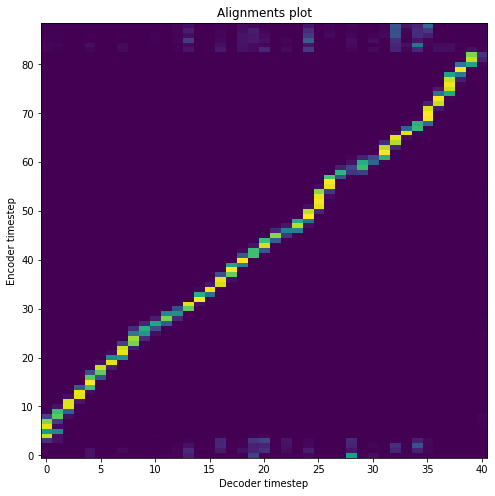

In [9]:
# Alignments plot
plt.figure(figsize=(8, 8))
plt.imshow(alignments[0], aspect="auto", origin="lower", interpolation="none")
plt.title('Alignments plot')
plt.xlabel('Decoder timestep')
plt.ylabel('Encoder timestep')
plt.show()

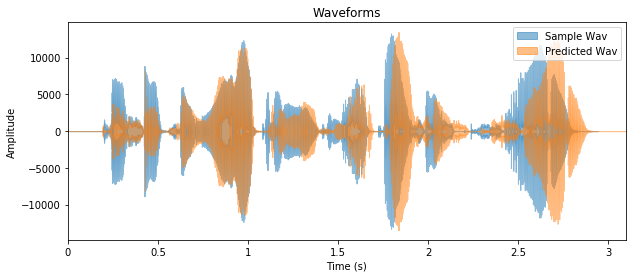

In [10]:
# WAV comparison
plt.figure(figsize=(10, 4))

librosa.display.waveplot(sample_wav.astype('float32'), sr=sample_sr, alpha=0.5, label="Sample Wav")
librosa.display.waveplot(wav.astype('float32'), sr=sr, alpha=0.5, label="Predicted Wav")

plt.title('Waveforms')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.legend()

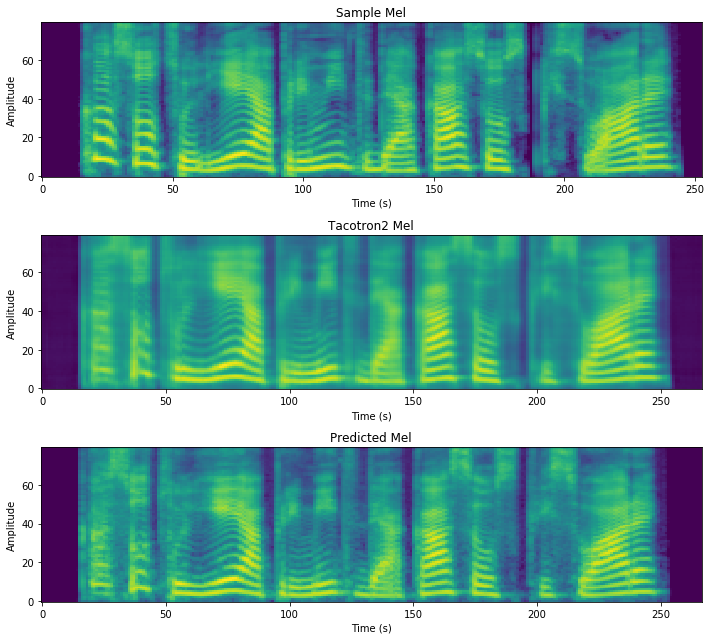

In [11]:
# Mel Spectrogram comparison
plt.figure(figsize=(10, 9))

plt.subplot(3, 1, 1)
plt.imshow(sample_mel[0], aspect="auto", origin="lower", interpolation="none")
plt.title('Sample Mel')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the predicted waveform
plt.subplot(3, 1, 2)
plt.imshow(tacotron2_mel[0], aspect="auto", origin="lower", interpolation="none")
plt.title('Tacotron2 Mel')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Plot the predicted waveform
plt.subplot(3, 1, 3)
plt.imshow(e2e_mel[0], aspect="auto", origin="lower", interpolation="none")
plt.title('Predicted Mel')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

In [12]:
# Mel Cepstral Distortion (MCD)
def compute_mcd(ref_audio, synth_audio, sr=22050, n_mfcc=13):
    ref_audio = ref_audio.astype('float32')
    synth_audio = synth_audio.astype('float32')
    
    min_len = min(len(ref_audio), len(synth_audio))
    ref_audio = ref_audio[:min_len]
    synth_audio = synth_audio[:min_len]

    # Compute MFCCs for both signals
    mfcc_ref = librosa.feature.mfcc(ref_audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_synth = librosa.feature.mfcc(synth_audio, sr=sr, n_mfcc=n_mfcc)
    
    mcd = np.mean(np.sqrt(2 * np.sum((mfcc_ref - mfcc_synth)**2, axis=0)))
    return mcd

mcd = compute_mcd(sample_wav, wav, sr)

mcd

155.70250379878203

In [13]:
# Mel Cepstral Distortion with Dynamic Time Warping (MCD-DTW)
def compute_mcd_dtw(ref_audio, synth_audio, sr=22050, n_mfcc=13):
    ref_audio = ref_audio.astype('float32')
    synth_audio = synth_audio.astype('float32')
    
    # Compute MFCCs for both signals
    mfcc_ref = librosa.feature.mfcc(ref_audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_synth = librosa.feature.mfcc(synth_audio, sr=sr, n_mfcc=n_mfcc)
    
    # Transpose MFCC matrices for DTW alignment (time-major format)
    mfcc_ref = mfcc_ref.T
    mfcc_synth = mfcc_synth.T
    
    # Compute DTW distance between MFCC sequences
    _, d = fastdtw(mfcc_ref, mfcc_synth, dist=euclidean)
    
    # Compute MCD-DTW as the square root of the mean of DTW distances
    mcd_dtw = np.sqrt(np.mean(d))
    
    return mcd_dtw

compute_mcd_dtw(sample_wav, wav, sr)

mcd_dtw = compute_mcd_dtw(sample_wav, wav, sr)

mcd_dtw

8.122898588649342

In [14]:
# Short-Time Objective Intelligibility (STOI)
def compute_stoi_score(ref, syn, sr):

    # Ensure the length is the same
    min_len = min(len(ref), len(syn))
    ref = ref[:min_len]
    syn = syn[:min_len]

    score = stoi(ref, syn, sr, extended=False)
    return score

stoi_score = compute_stoi_score(sample_wav, wav, sr)

stoi_score

0.5679263342584976

In [15]:
def compute_pesq_score(ref, syn, sr):
    target_sr = 8000
    ref = librosa.resample(ref.astype('float32'), sr, target_sr)
    syn = librosa.resample(syn.astype('float32'), sr, target_sr)

    # Ensure the length is the same
    min_len = min(len(ref), len(syn))
    ref = ref[:min_len]
    syn = syn[:min_len]

    score = pesq(ref, syn, target_sr)
    return score
    
pesq_score = compute_pesq_score(sample_wav, wav, sr)

pesq_score

1.5467798709869385

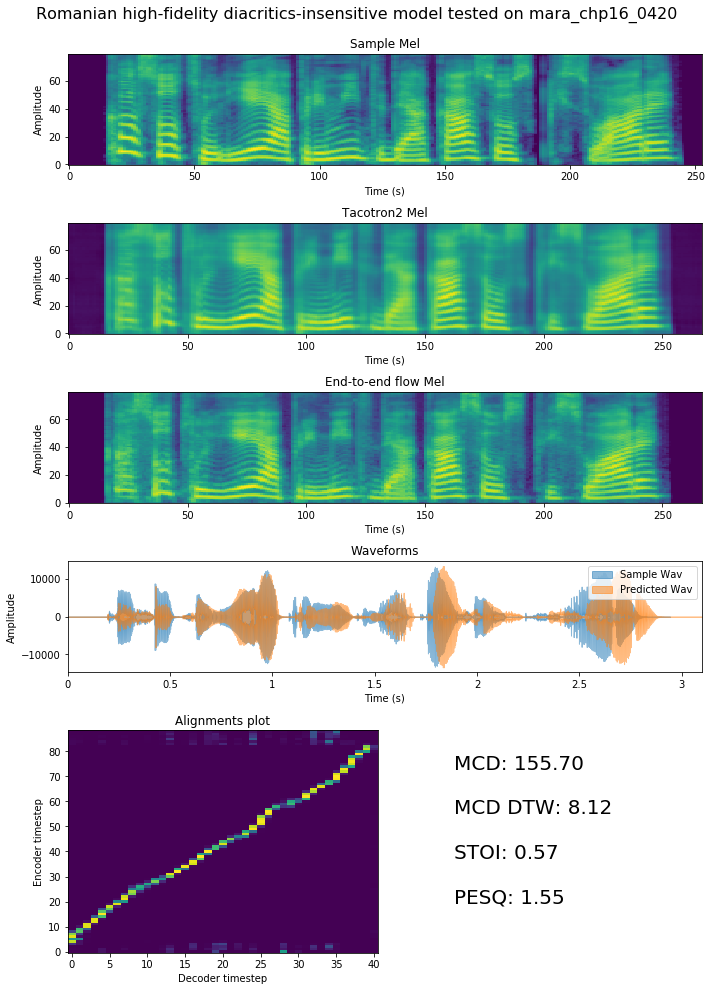

In [16]:
# Create a figure
fig = plt.figure(figsize=(10, 14))

# Create a GridSpec with height ratios to make the horizontal plots less tall
gs = gridspec.GridSpec(5, 2, height_ratios=[1, 1, 1, 1, 2])

# Create individual plots with different data
ax1 = fig.add_subplot(gs[0, :])
ax1.imshow(sample_mel[0], aspect="auto", origin="lower", interpolation="none")
ax1.set_title('Sample Mel')
ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Amplitude')

ax2 = fig.add_subplot(gs[1, :])
ax2.imshow(tacotron2_mel[0], aspect="auto", origin="lower", interpolation="none")
ax2.set_title('Tacotron2 Mel')
ax2.set_xlabel('Time (s)')
ax2.set_ylabel('Amplitude')

ax3 = fig.add_subplot(gs[2, :])
ax3.imshow(e2e_mel[0], aspect="auto", origin="lower", interpolation="none")
ax3.set_title('End-to-end flow Mel')
ax3.set_xlabel('Time (s)')
ax3.set_ylabel('Amplitude')

ax4 = fig.add_subplot(gs[3, :])
librosa.display.waveplot(sample_wav.astype('float32'), sr=sample_sr, alpha=0.5, label="Sample Wav", ax=ax4)
librosa.display.waveplot(wav.astype('float32'), sr=sr, alpha=0.5, label="Predicted Wav", ax=ax4)
ax4.set_title('Waveforms')
ax4.set_xlabel('Time (s)')
ax4.set_ylabel('Amplitude')
ax4.legend()

ax5 = fig.add_subplot(gs[4, 0])
ax5.imshow(alignments[0], aspect="auto", origin="lower", interpolation="none")
ax5.set_title('Alignments plot')
ax5.set_xlabel('Decoder timestep')
ax5.set_ylabel('Encoder timestep')

ax6 = fig.add_subplot(gs[4, 1])
ax6.text(0.2, 0.85, f'MCD: {mcd:.2f}', ha='left', va='center', fontsize=20)
ax6.text(0.2, 0.65, f'MCD DTW: {mcd_dtw:.2f}', ha='left', va='center', fontsize=20)
ax6.text(0.2, 0.45, f'STOI: {stoi_score:.2f}', ha='left', va='center', fontsize=20)
ax6.text(0.2, 0.25, f'PESQ: {pesq_score:.2f}', ha='left', va='center', fontsize=20)
ax6.axis('off')

# Add a main title for the entire figure
fig.suptitle('Romanian high-fidelity diacritics-insensitive model tested on mara_chp16_0420', fontsize=16)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Display the plots
plt.show()
